In [1]:
from IPython.display import clear_output, display
import requests
from bs4 import BeautifulSoup
import json
import re
from datetime import datetime, date
import pandas as pd
import numpy as np
from os.path import exists
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
# Appending data paths
sys.path.append(os.getcwd() + '\\parsed_data')

# Broker - review page map
bankiru_broker_urls = {'тинькофф': 'https://www.banki.ru/investment/responses/company/broker/tcs/',
                       'бкс': 'https://www.banki.ru/investment/responses/company/broker/bks/',
                       'втб': 'https://www.banki.ru/investment/responses/company/broker/vtb/',
                       'альфа': 'https://www.banki.ru/investment/responses/company/broker/alfa-direkt/'}


## Parsing functions

In [2]:
def get_max_page_num_on_bankiru(url: str) -> int:
    '''
    Returns the number of the last page for pagenation
    '''
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    try:
        max_page = soup.find_all('li', attrs={'class': re.compile("ui-pagination.+number", re.I)})[-1].text.strip()
    except IndexError:
        max_page = 0
    
    return int(max_page)


def get_bankiru_pagenation(url: str) -> list:
    '''
    Generates a list of pages to visit
    '''
    max_page = get_max_page_num_on_bankiru(url)
    return [f'{url}?page={page_num}' for page_num in range(1, max_page + 1)]


def parse_json_data_from_bankiru(parsed_url: BeautifulSoup) -> dict:
    '''
    Parse useful info from banki.ru review pages with JSON
    '''
    # Get JSON from HTML
    json_data = json.loads(parsed_url.find("script", attrs={"type": "application/ld+json"}).text, strict=False)
    
    # List all dates
    publish_date = [review['datePublished'] for review in json_data['review']]
    # List all reviews' text
    description = [review['description'] for review in json_data['review']]
    # List all rating values
    rating_val = [review['reviewRating']['ratingValue'] for review in json_data['review']]
    
    return {'publish_date': publish_date, 
            'description': description, 
            'rating_val': rating_val}


def parse_data_from_bankiru(parsed_url: BeautifulSoup) -> dict:
    '''
    Parse useful info from banki.ru review pages with html tags
    '''
    review_cards = soup.find('div', class_=re.compile('responses-list mobile', re.I))\
                      .find_all('article', class_='responses__item')
    
    existance_check = lambda x: x.text.strip() if x else None
    
    # List all dates
    publish_date = [card.find('time', {'data-test': 'responses-datetime'}).text.strip() for card in review_cards]
    # List all review headers
    review_header = [card.find('a', {'data-test': 'responses-header'}).text.strip() for card in review_cards]
    # List all reviews' text
    description = [card.find('div', class_=re.compile('markup-inside-small', re.I)).text.strip() for card in review_cards]
    # List all rating values
    rating_val = [existance_check(card.find('span', {'data-test': 'responses-rating-grade'})) for card in review_cards]
    # List all response statuses
    response_status = [existance_check(card.find('span', {'data-test': 'responses-status'})) for card in review_cards]
    
    return {'publish_date': publish_date, 
            'review_header': review_header,
            'description': description, 
            'rating_val': rating_val, 
            'response_status': response_status}


def get_name_from_bankiru_json(soup_element: BeautifulSoup) -> str:
    '''
    Gets real broker name from json element
    '''
    return json.loads(soup_element.text)['name']

## Prepare broker urls and their real names

In [160]:
# Url with info about brokers from banki.ru
common_url = 'https://www.banki.ru/investment/responses/'

# Getting all real broker names
response = requests.get(common_url)
soup = BeautifulSoup(response.text, 'lxml')
all_brokers = soup.find_all('script', {'type': "application/ld+json"})[:-1]
real_broker_names = [get_name_from_bankiru_json(broker_soup_element) for broker_soup_element in all_brokers]

# Parsing necessary tags from java code chunk 
other_brokers = '''32: `/investment/brokers/tcs/`, 
                   5: `/investment/brokers/finam/`, 
                   47: `/investment/brokers/rshb/`, 
                   2: `/investment/brokers/vtb/`, 
                   518: `/investment/brokers/otkritie/`, 
                   3: `/investment/brokers/sberbank/`, 
                   4: `/investment/brokers/bks/`, 
                   10: `/investment/brokers/kitfinansbroker/`, 
                   23: `/investment/brokers/sitibank/`, 
                   7: `/investment/brokers/alfa-direkt/`, 
                   27: `/investment/brokers/cifra-broker/`, 
                   257: `/investment/brokers/piter-trust/`, 
                   35: `/investment/brokers/uralcibcapital/`, 
                   462: `/investment/brokers/mtsbank/`, 
                   49: `/investment/brokers/raiffeisen/`, 
                   12: `/investment/brokers/gazprombank/`, 
                   84: `/investment/brokers/renbroker/`
'''
broker_tags = re.findall(r'brokers/(.+/)`', other_brokers)

# Forming dictionary out of mined data
url_body = 'https://www.banki.ru/investment/responses/company/broker/'
bankiru_broker_urls = {name: url_body + tag for name, tag in zip(real_broker_names, broker_tags)}

bankiru_broker_urls

{'Тинькофф Инвестиции': 'https://www.banki.ru/investment/responses/company/broker/tcs/',
 'ИК Финам': 'https://www.banki.ru/investment/responses/company/broker/finam/',
 'Россельхозбанк': 'https://www.banki.ru/investment/responses/company/broker/rshb/',
 'ВТБ Мои Инвестиции / Банк ВТБ': 'https://www.banki.ru/investment/responses/company/broker/vtb/',
 'Открытие Брокер': 'https://www.banki.ru/investment/responses/company/broker/otkritie/',
 'ПАО Сбербанк': 'https://www.banki.ru/investment/responses/company/broker/sberbank/',
 'БКС Мир Инвестиций': 'https://www.banki.ru/investment/responses/company/broker/bks/',
 'КИТ Финанс Брокер': 'https://www.banki.ru/investment/responses/company/broker/kitfinansbroker/',
 'Ситибанк': 'https://www.banki.ru/investment/responses/company/broker/sitibank/',
 'Альфа-Банк': 'https://www.banki.ru/investment/responses/company/broker/alfa-direkt/',
 '«Цифра брокер»': 'https://www.banki.ru/investment/responses/company/broker/cifra-broker/',
 'Питер Траст': 'ht

## Parsing banki.ru

In [3]:
file_name = 'initial_banki_data.csv'
file_path = f'./parsed_data/{file_name}'

In [162]:
for broker_name, initial_url in bankiru_broker_urls.items():
    for i, paged_url in enumerate(get_bankiru_pagenation(initial_url)):
        if not i % 10:
            clear_output()
        print(paged_url)
        response = requests.get(paged_url)
        soup = BeautifulSoup(response.text, 'lxml')
        data_dict = parse_data_from_bankiru(soup)
        print(list(zip(*data_dict.values()))[-1])
        parsed_data = pd.DataFrame(data_dict)
        parsed_data.insert(0, 'broker_name', broker_name)
        parsed_data.to_csv(file_name, 
                           mode='a' if exists(file_name) else 'w', 
                           sep='\t', 
                           index=False,
                           header = not exists(file_name))
clear_output()

## Data research

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4612 entries, 0 to 4611
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   broker_name      4612 non-null   object 
 1   publish_date     4612 non-null   object 
 2   review_header    4612 non-null   object 
 3   description      4612 non-null   object 
 4   rating_val       4301 non-null   float64
 5   response_status  4612 non-null   object 
dtypes: float64(1), object(5)
memory usage: 216.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4301 entries, 0 to 4300
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   broker_name      4301 non-null   object
 1   publish_date     4301 non-null   object
 2   review_header    4301 non-null   object
 3   description      4301 non-null   object
 4   rating_val       4301 non-null   int8  
 5   response_status  4301 non-null   object
dtype

,broker_name,publish_date,review_header,description,rating_val,response_status
4296,Газпромбанк,2022-07-28,Позор! ГПБ Инвестиции не выполняет обязательства,20.07.22 через приложение Газпром инвестиции р...,1,Засчитана
4297,Ренессанс Брокер,2023-03-16,Пропал портфель с инвестициями в приложении банка,После очередных технических работ пропал портф...,1,Засчитана
4298,Ренессанс Брокер,2022-11-23,В общем то все хорошо,В начале 2022 года оформила брокерский счет в ...,5,Не засчитана
4299,Ренессанс Брокер,2022-10-12,Условия открытия брокерского счета не соответс...,"«Несколько месяцев являюсь клиентом банка, исп...",1,Засчитана
4300,Ренессанс Брокер,2022-10-05,Брокерское обслуживание,По состоянию на начало октября 2022 обслуживан...,4,Не засчитана


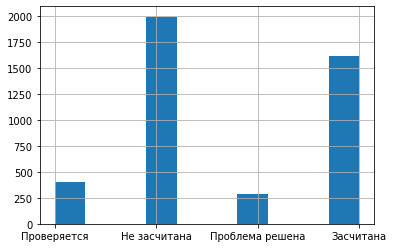

In [31]:
# Load the data we got
# All rows with empty response_status are Accepted
review_data = pd.read_csv(file_name, sep = '\t')\
                .fillna({'response_status': 'Засчитана'})
review_data.info()
print()

# Drop rows rating value (our target feature)
review_data = review_data.dropna()\
                         .astype({'rating_val': 'int8'})\
                         .reset_index(drop=True)

# Format dates
source_date_format = '%d.%m.%Y %H:%M'
format_date = lambda x: datetime.strptime(x, source_date_format)\
                        .date()
review_data['publish_date'] = review_data['publish_date'].apply(format_date)
review_data.info()
print()

# Output broker reviews wo got
print('List of unique brokers: ', review_data['broker_name'].unique().tolist(), sep='\n', end='\n\n')
display(review_data.tail())

# 
review_data['response_status'].hist()
plt.show()

In [32]:
review_data = review_data[~review_data['response_status'].isin(['Проверяется'])]
review_data['response_status'] = review_data['response_status'].str.replace('Проблема решена', 'Засчитана')
review_data.reset_index(drop=True, inplace=True)
print(review_data.drop_duplicates().shape)
print(review_data.shape)
review_data.tail(5)

(3900, 6)
(3900, 6)


,broker_name,publish_date,review_header,description,rating_val,response_status
3895,Газпромбанк,2022-07-28,Позор! ГПБ Инвестиции не выполняет обязательства,20.07.22 через приложение Газпром инвестиции р...,1,Засчитана
3896,Ренессанс Брокер,2023-03-16,Пропал портфель с инвестициями в приложении банка,После очередных технических работ пропал портф...,1,Засчитана
3897,Ренессанс Брокер,2022-11-23,В общем то все хорошо,В начале 2022 года оформила брокерский счет в ...,5,Не засчитана
3898,Ренессанс Брокер,2022-10-12,Условия открытия брокерского счета не соответс...,"«Несколько месяцев являюсь клиентом банка, исп...",1,Засчитана
3899,Ренессанс Брокер,2022-10-05,Брокерское обслуживание,По состоянию на начало октября 2022 обслуживан...,4,Не засчитана


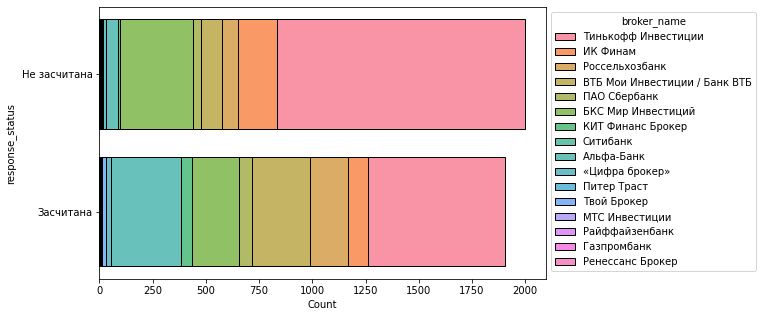

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
sns.histplot(data=review_data, 
             y="response_status", 
             hue="broker_name", 
             multiple="stack",
             shrink=.8)
sns.move_legend(axes, "upper left", bbox_to_anchor=(1, 1))
# plt.xscale('log')
plt.show()

In [59]:
grp = review_data.groupby(['broker_name', 'response_status'], as_index=False).agg({'review_header': 'count'})
res_tbl = grp[['broker_name']].drop_duplicates()
ratio_tbl = res_tbl.merge(grp.query('response_status == "Засчитана"')[['broker_name', 'review_header']], on='broker_name', how='left')\
       .rename(columns={'review_header': 'accepted'})\
       .merge(grp.query('response_status == "Не засчитана"')[['broker_name', 'review_header']], on='broker_name', how='left')\
       .rename(columns={'review_header': 'not_accepted'})
    
ratio_tbl['ratio'] = ratio_tbl['accepted']/ratio_tbl['not_accepted']

ratio_tbl
# .drop(columns=['accepted', 'not_accepted'])

,broker_name,accepted,not_accepted,ratio
0,«Цифра брокер»,21,14.0,1.500000
1,Альфа-Банк,331,60.0,5.516667
2,БКС Мир Инвестиций,222,341.0,0.651026
3,ВТБ Мои Инвестиции / Банк ВТБ,272,100.0,2.720000
4,Газпромбанк,4,3.0,1.333333
5,ИК Финам,91,181.0,0.502762
6,КИТ Финанс Брокер,48,8.0,6.000000
7,МТС Инвестиции,3,NaN,NaN
8,ПАО Сбербанк,61,37.0,1.648649
9,Питер Траст,1,3.0,0.333333


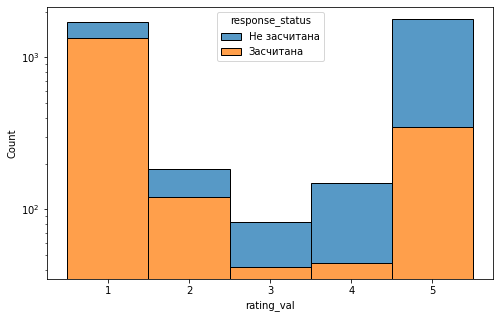

In [65]:
review_data_to_disp = review_data.copy()
review_data_to_disp['rating_val'] = pd.Categorical(review_data.astype({'rating_val': 'str'})['rating_val'], 
                                                   ['1', '2', '3', '4', '5'])
plt.figure(figsize=(8, 5))
sns.histplot(data=review_data_to_disp, 
             x="rating_val", 
             hue="response_status", 
             multiple="stack")
plt.yscale('log')
plt.show()

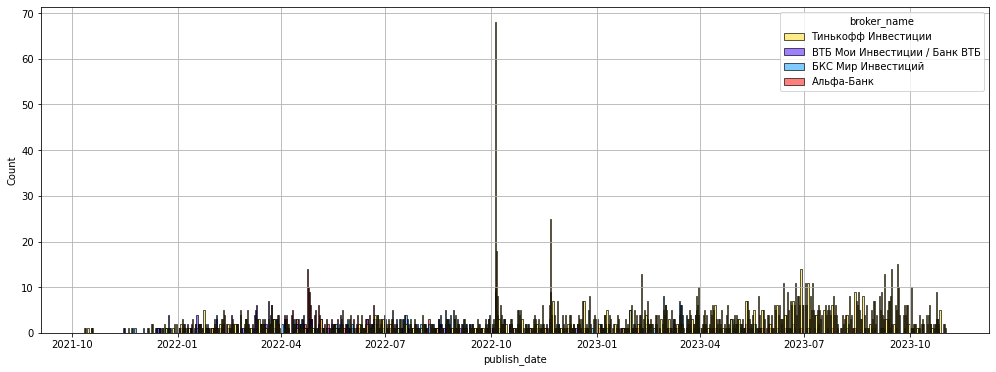

In [66]:
brokers_of_interest = ['Тинькофф Инвестиции', 'ВТБ Мои Инвестиции / Банк ВТБ', 'БКС Мир Инвестиций', 'Альфа-Банк']
palette_list = ["#FDDA0D", "#3F00FF", "#0096FF", "#FF0000"]
broker_palette_dict = {broker: color for broker, color in zip(brokers_of_interest, palette_list)}

selected_brokers = brokers_of_interest
palette = [color for broker, color in broker_palette_dict.items() if broker in selected_brokers]


fig, axes = plt.subplots(1, 1, figsize=(17, 6))
sns.histplot(ax=axes,
             data=review_data[review_data_to_disp['broker_name'].isin(selected_brokers)], 
             x="publish_date", 
             hue="broker_name", 
             element="bars",
             palette=sns.color_palette(palette, len(selected_brokers)),
             kde=True if len(selected_brokers) == 1 else False,
             linewidth=0.65
            )
plt.grid()
plt.show()

In [77]:
datetime.strptime('2021-12-22', '%Y-%m-%d').date()

datetime.date(2021, 12, 22)

In [82]:
kde_data = review_data.groupby(['broker_name', 'publish_date'], as_index=False)\
                      .agg({'review_header': 'count'})
# format_date = lambda x: datetime.strptime(x, '%Y-%m-%d')\
#                         .date()
# kde_data['publish_date'] = kde_data['publish_date'].apply(format_date)
    

kde_data
sns.kdeplot(data=kde_data, x="publish_date")
plt.show()

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

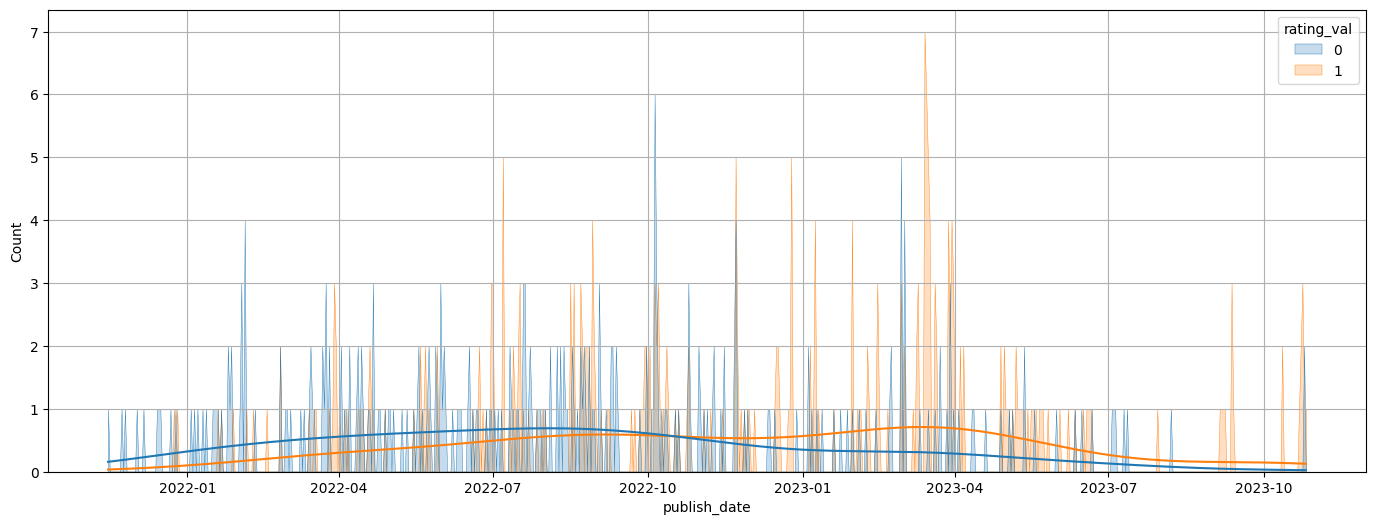

In [50]:
fig, axes = plt.subplots(1, 1, figsize=(17, 6))
sns.histplot(ax=axes,
             data=review_data[review_data['broker_name'].isin(['БКС Мир Инвестиций'])]\
                             .replace([1, 2, 3, 4, 5], [0, 0, 0, 1, 1]), 
             x="publish_date", 
             hue="rating_val", 
             element="poly",
             kde=True,
             linewidths=0.3
            )
plt.grid()

In [51]:
review_data.to_csv('modified_banki_parsed_data.csv', sep='\t', index=False)